<hr/>

<hr/>

In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install toad

     |████████████████████████████████| 14.8 MB 2.1 MB/s            
     |████████████████████████████████| 292 kB 62.9 MB/s            
     |████████████████████████████████| 2.0 MB 48.5 MB/s            
     |████████████████████████████████| 14.8 MB 42.0 MB/s            
     |████████████████████████████████| 14.8 MB 40.0 MB/s            
     |████████████████████████████████| 14.8 MB 51.5 MB/s            
     |████████████████████████████████| 14.8 MB 44.4 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.12
    Uninstalling Cython-0.29.12:
      Successfully uninstalled Cython-0.29.12
ERROR: pip's dependency resolver does not curren

## <span id="1"></span> ** 1. Overview **

## <span id="2"></span> ** 2. Importing Libraries and Reading the Dataset **

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.core.display import display, HTML
from sklearn import datasets
from matplotlib import pyplot as plt
import toad
import jieba
from sklearn.model_selection import train_test_split
sns.set_style('darkgrid')

In [165]:
import time
from sklearn.datasets import load_boston
dataset = pd.read_excel("/input/fxmonth/USD_CAD_Month.xlsx")
dataset.columns

Index(['Underlying', 'Type', 'Strike', 'Expiry', 'Notional', 'Curr', 'Premium',
       'Curr.1', 'Style', 'Code', 'Clr', 'Trd Time'],
      dtype='object')

In [166]:
d_min = pd.read_excel("/input/minute/USD_CAD_Minute.xlsx")
d_min.head()

Date      ER
0  2022-11-24T00:00:00.000Z  1.3339
1  2022-11-23T23:59:00.000Z  1.3339
2  2022-11-23T23:58:00.000Z  1.3341
3  2022-11-23T23:57:00.000Z  1.3343
4  2022-11-23T23:56:00.000Z  1.3346

**Converts the string time to a unix timestamp**

In [167]:
def Changetime(str1):
    try:
        str1 = str(str1)
        Unixtime = int(time.mktime(time.strptime(str1, '%m/%d/%Y %H:%M:%S'))*1000)
    except:
        print("**"+str1)
    return Unixtime


In [168]:
def Changetime1(str1):
    try:
        str1 = str(str1)
        Unixtime = int(time.mktime(time.strptime(str1, '%Y-%m-%dT%H:%M:%S.000Z'))*1000)
    except:
        print("**"+str1)
    return Unixtime

Changetime1('2022-11-24T00:00:00.000Z')

1669248000000

per ms
1 1ms
1s 1000
1hour 3600000
1day 86400000
1week 604800000
1month 2629743000

In [169]:
dataset["Trd Time"] = dataset["Trd Time"].apply(Changetime)


In [170]:
d_min["ER"]

0        1.3339
1        1.3339
2        1.3341
3        1.3343
4        1.3346
5        1.3344
6        1.3345
7        1.3345
8        1.3345
9        1.3346
10       1.3347
11       1.3346
12       1.3347
13       1.3348
14       1.3348
15       1.3346
16       1.3348
17       1.3348
18       1.3347
19       1.3346
20       1.3347
21       1.3347
22       1.3347
23       1.3348
24       1.3347
25       1.3347
26       1.3347
27       1.3346
28       1.3346
29       1.3346
          ...  
38809    1.3710
38810    1.3712
38811    1.3710
38812    1.3712
38813    1.3712
38814    1.3715
38815    1.3718
38816    1.3715
38817    1.3715
38818    1.3713
38819    1.3711
38820    1.3709
38821    1.3707
38822    1.3708
38823    1.3708
38824    1.3708
38825    1.3709
38826    1.3711
38827    1.3713
38828    1.3714
38829    1.3714
38830    1.3715
38831    1.3714
38832    1.3713
38833    1.3713
38834    1.3710
38835    1.3709
38836    1.3707
38837    1.3706
38838    1.3705
Name: ER, Length: 38839,

In [171]:
d_min["Date"] = d_min["Date"].apply(Changetime1)

In [172]:
dataset.head()

Underlying Type  Strike    Expiry  Notional Curr   Premium  \
0  USD CAD Vanilla Option    C  1.4050  08/18/23  20000000  USD  264500.0   
1  USD CAD Vanilla Option    C  1.3385  11/21/22  15000000  USD   21000.0   
2  USD CAD Vanilla Option    C  1.3450  11/30/22  30000000  USD   96000.0   
3  USD CAD Vanilla Option    C  1.3635  12/20/22  30000000  USD  128250.0   
4  USD CAD Vanilla Option    C  1.4050  08/18/23  30000000  USD  396750.0   

  Curr.1 Style Code Clr       Trd Time  
0    USD    EU   TR   U  1668789236000  
1    USD    EU   TR   U  1668789038000  
2    USD    EU   TR   U  1668788844000  
3    USD    EU   TR   U  1668788449000  
4    USD    EU   TR   U  1668788435000

## <span id="2"></span> ** 2. data encoding **

In [173]:
dataset["Trd Time"].isnull().sum()
print(len(dataset["Trd Time"]))
print(dataset["Trd Time"][len(dataset["Trd Time"])-1])

2320
1666168731000


**find er after 1min / 30 min / 1 hour /1 day**

In [174]:
def find1min_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>10000 and (a-i)<10*60000):
            return j
    return -1
dataset["1min"] = dataset["Trd Time"].apply(find1min_er)
dataset["1min"].value_counts()

1.3686    38
1.3638    33
1.3539    31
1.3700    27
1.3276    21
1.3726    19
1.3255    17
1.3544    17
1.3554    16
1.3737    15
1.3731    15
1.3556    15
1.3610    15
1.3287    15
1.3594    14
1.3273    14
1.3274    14
1.3487    14
1.3712    14
1.3523    13
1.3730    13
1.3617    13
1.3297    12
1.3736    12
1.3622    12
1.3733    12
1.3738    12
1.3715    12
1.3723    11
1.3637    11
          ..
1.3375     1
1.3356     1
1.3424     1
1.3770     1
1.3579     1
1.3663     1
1.3305     1
1.3317     1
1.3460     1
1.3508     1
1.3254     1
1.3526     1
1.3403     1
1.3237     1
1.3586     1
1.3518     1
1.3673     1
1.3406     1
1.3835     1
1.3665     1
1.3365     1
1.3244     1
1.3482     1
1.3786     1
1.3414     1
1.3327     1
1.3497     1
1.3428     1
1.3447     1
1.3448     1
Name: 1min, Length: 500, dtype: int64

In [175]:
def find30min_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>10*60000 and (a-i)<50*60000):
            return j
    return -1
dataset["30min"] = dataset["Trd Time"].apply(find1min_er)
dataset["30min"].value_counts()

1.3686    38
1.3638    33
1.3539    31
1.3700    27
1.3276    21
1.3726    19
1.3255    17
1.3544    17
1.3554    16
1.3737    15
1.3731    15
1.3556    15
1.3610    15
1.3287    15
1.3594    14
1.3273    14
1.3274    14
1.3487    14
1.3712    14
1.3523    13
1.3730    13
1.3617    13
1.3297    12
1.3736    12
1.3622    12
1.3733    12
1.3738    12
1.3715    12
1.3723    11
1.3637    11
          ..
1.3375     1
1.3356     1
1.3424     1
1.3770     1
1.3579     1
1.3663     1
1.3305     1
1.3317     1
1.3460     1
1.3508     1
1.3254     1
1.3526     1
1.3403     1
1.3237     1
1.3586     1
1.3518     1
1.3673     1
1.3406     1
1.3835     1
1.3665     1
1.3365     1
1.3244     1
1.3482     1
1.3786     1
1.3414     1
1.3327     1
1.3497     1
1.3428     1
1.3447     1
1.3448     1
Name: 30min, Length: 500, dtype: int64

In [176]:
def find1h_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>60*60000 and (a-i)<120*60000):
            return j
    return -1
dataset["1h"] = dataset["Trd Time"].apply(find1min_er)
dataset["1h"].value_counts()

1.3686    38
1.3638    33
1.3539    31
1.3700    27
1.3276    21
1.3726    19
1.3255    17
1.3544    17
1.3554    16
1.3737    15
1.3731    15
1.3556    15
1.3610    15
1.3287    15
1.3594    14
1.3273    14
1.3274    14
1.3487    14
1.3712    14
1.3523    13
1.3730    13
1.3617    13
1.3297    12
1.3736    12
1.3622    12
1.3733    12
1.3738    12
1.3715    12
1.3723    11
1.3637    11
          ..
1.3375     1
1.3356     1
1.3424     1
1.3770     1
1.3579     1
1.3663     1
1.3305     1
1.3317     1
1.3460     1
1.3508     1
1.3254     1
1.3526     1
1.3403     1
1.3237     1
1.3586     1
1.3518     1
1.3673     1
1.3406     1
1.3835     1
1.3665     1
1.3365     1
1.3244     1
1.3482     1
1.3786     1
1.3414     1
1.3327     1
1.3497     1
1.3428     1
1.3447     1
1.3448     1
Name: 1h, Length: 500, dtype: int64

In [177]:
def find1d_er(a):
    for i,j in zip(d_min['Date'], d_min['EUR=']):
        if((a-i)>24*60*60000 and (a-i)<48*60*60000):
            return j
    return -1
dataset["1d"] = dataset["Trd Time"].apply(find1min_er)
dataset["1d"].value_counts()

1.3686    38
1.3638    33
1.3539    31
1.3700    27
1.3276    21
1.3726    19
1.3255    17
1.3544    17
1.3554    16
1.3737    15
1.3731    15
1.3556    15
1.3610    15
1.3287    15
1.3594    14
1.3273    14
1.3274    14
1.3487    14
1.3712    14
1.3523    13
1.3730    13
1.3617    13
1.3297    12
1.3736    12
1.3622    12
1.3733    12
1.3738    12
1.3715    12
1.3723    11
1.3637    11
          ..
1.3375     1
1.3356     1
1.3424     1
1.3770     1
1.3579     1
1.3663     1
1.3305     1
1.3317     1
1.3460     1
1.3508     1
1.3254     1
1.3526     1
1.3403     1
1.3237     1
1.3586     1
1.3518     1
1.3673     1
1.3406     1
1.3835     1
1.3665     1
1.3365     1
1.3244     1
1.3482     1
1.3786     1
1.3414     1
1.3327     1
1.3497     1
1.3428     1
1.3447     1
1.3448     1
Name: 1d, Length: 500, dtype: int64

In [178]:
dataset.head()

Underlying Type  Strike    Expiry  Notional Curr   Premium  \
0  USD CAD Vanilla Option    C  1.4050  08/18/23  20000000  USD  264500.0   
1  USD CAD Vanilla Option    C  1.3385  11/21/22  15000000  USD   21000.0   
2  USD CAD Vanilla Option    C  1.3450  11/30/22  30000000  USD   96000.0   
3  USD CAD Vanilla Option    C  1.3635  12/20/22  30000000  USD  128250.0   
4  USD CAD Vanilla Option    C  1.4050  08/18/23  30000000  USD  396750.0   

  Curr.1 Style Code Clr       Trd Time    1min   30min      1h      1d  
0    USD    EU   TR   U  1668789236000  1.3374  1.3374  1.3374  1.3374  
1    USD    EU   TR   U  1668789038000  1.3373  1.3373  1.3373  1.3373  
2    USD    EU   TR   U  1668788844000  1.3371  1.3371  1.3371  1.3371  
3    USD    EU   TR   U  1668788449000  1.3374  1.3374  1.3374  1.3374  
4    USD    EU   TR   U  1668788435000  1.3374  1.3374  1.3374  1.3374

In [179]:
def hotEncoding(NAME):
    value = dataset[NAME].value_counts()
    value_map = dict((v, i) for i,v in enumerate(value.index))
    dataset[NAME] = dataset.replace({NAME:value_map})[NAME]
hotEncoding('Underlying') 

In [180]:
def typecoding(NAME): 
    value1 = dataset[NAME].astype('category')
    dataset[NAME] = value1.cat.codes
typecoding('Curr')
typecoding('Type')
typecoding('Curr.1')
typecoding('Style')
typecoding('Code')
typecoding('Clr')
dataset['Underlying'] = dataset['Underlying'] +1
dataset['Type'] = dataset['Type'] +1
dataset['Curr'] = dataset['Curr'] +1
dataset['Curr.1'] = dataset['Curr.1'] +1
dataset.head()

Underlying  Type  Strike    Expiry  Notional  Curr   Premium  Curr.1  \
0           1     1  1.4050  08/18/23  20000000     1  264500.0       2   
1           1     1  1.3385  11/21/22  15000000     1   21000.0       2   
2           1     1  1.3450  11/30/22  30000000     1   96000.0       2   
3           1     1  1.3635  12/20/22  30000000     1  128250.0       2   
4           1     1  1.4050  08/18/23  30000000     1  396750.0       2   

   Style  Code  Clr       Trd Time    1min   30min      1h      1d  
0      0     2    0  1668789236000  1.3374  1.3374  1.3374  1.3374  
1      0     2    0  1668789038000  1.3373  1.3373  1.3373  1.3373  
2      0     2    0  1668788844000  1.3371  1.3371  1.3371  1.3371  
3      0     2    0  1668788449000  1.3374  1.3374  1.3374  1.3374  
4      0     2    0  1668788435000  1.3374  1.3374  1.3374  1.3374

In [181]:
dataset = dataset.drop(['Expiry','Clr'], axis=1)
# dataset['toprice'] = dataset['Notional']/2+dataset['Premium']
# dataset['delrate'] = dataset['Premium']/(dataset['Curr']+1)
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
dataset.head()

Underlying  Type  Strike  Notional  Curr   Premium  Curr.1  Style  Code  \
0           1     1  1.4050  20000000     1  264500.0       2      0     2   
1           1     1  1.3385  15000000     1   21000.0       2      0     2   
2           1     1  1.3450  30000000     1   96000.0       2      0     2   
3           1     1  1.3635  30000000     1  128250.0       2      0     2   
4           1     1  1.4050  30000000     1  396750.0       2      0     2   

        Trd Time    1min   30min      1h      1d  
0  1668789236000  1.3374  1.3374  1.3374  1.3374  
1  1668789038000  1.3373  1.3373  1.3373  1.3373  
2  1668788844000  1.3371  1.3371  1.3371  1.3371  
3  1668788449000  1.3374  1.3374  1.3374  1.3374  
4  1668788435000  1.3374  1.3374  1.3374  1.3374

## <span id="3"></span> ** 3. Data Analysis **

### <span id="4"></span> ** Data Preprocessing **

Are there missing values? There isn't any missing values as shown below.

In [182]:
dataset= dataset.dropna()


### <span id="5"></span> ** using toad to perform exploratory data analysis and visualization**

In [183]:
dataset.isnull().sum()

Underlying    0
Type          0
Strike        0
Notional      0
Curr          0
Premium       0
Curr.1        0
Style         0
Code          0
Trd Time      0
1min          0
30min         0
1h            0
1d            0
dtype: int64

In [184]:
tance = toad.detector.detect(dataset)

In [185]:
tance

type  size missing  unique  mean_or_top1   std_or_top2  \
Underlying    int64  2320   0.00%       1  1.000000e+00  0.000000e+00   
Type           int8  2320   0.00%       1  1.000000e+00  0.000000e+00   
Strike      float64  2320   0.00%     409  1.363636e+00  6.758563e-02   
Notional      int64  2320   0.00%     114  2.920066e+07  3.519192e+07   
Curr           int8  2320   0.00%       1  1.000000e+00  0.000000e+00   
Premium     float64  2320   0.00%    1580  3.722396e+05  1.063659e+06   
Curr.1         int8  2320   0.00%       2  1.975431e+00  1.548408e-01   
Style          int8  2320   0.00%       1  0.000000e+00  0.000000e+00   
Code           int8  2320   0.00%       3  1.954310e+00  2.959821e-01   
Trd Time      int64  2320   0.00%    1753  1.667495e+12  7.796389e+08   
1min        float64  2320   0.00%     500  1.354647e+00  1.693318e-02   
30min       float64  2320   0.00%     500  1.354647e+00  1.693318e-02   
1h          float64  2320   0.00%     500  1.354647e+00  1.693318e-02   
1d          float64  2320   0.00%     500  1.354647e+00  1.693318e-02   

             min_or_top3    1%_or_top4   10%_or_top5  50%_or_bottom5  \
Underlying  1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Type        1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Strike      1.000000e-04  1.280000e+00  1.324480e+00    1.360500e+00   
Notional    4.000000e+04  2.000000e+05  2.000000e+06    2.000000e+07   
Curr        1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Premium     0.000000e+00  0.000000e+00  1.372500e+03    1.567500e+05   
Curr.1      1.000000e+00  1.000000e+00  2.000000e+00    2.000000e+00   
Style       0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
Code        0.000000e+00  0.000000e+00  2.000000e+00    2.000000e+00   
Trd Time    1.666169e+12  1.666178e+12  1.666357e+12    1.667468e+12   
1min        1.322900e+00  1.324700e+00  1.328500e+00    1.356500e+00   
30min       1.322900e+00  1.324700e+00  1.328500e+00    1.356500e+00   
1h          1.322900e+00  1.324700e+00  1.328500e+00    1.356500e+00   
1d          1.322900e+00  1.324700e+00  1.328500e+00    1.356500e+00   

            75%_or_bottom4  90%_or_bottom3  99%_or_bottom2  max_or_bottom1  
Underlying    1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Type          1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Strike        1.380000e+00    1.410000e+00    1.546310e+00    1.900000e+00  
Notional      3.100000e+07    7.000000e+07    2.000000e+08    2.500000e+08  
Curr          1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Premium       3.660000e+05    7.006875e+05    3.980958e+06    1.828900e+07  
Curr.1        2.000000e+00    2.000000e+00    2.000000e+00    2.000000e+00  
Style         0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
Code          2.000000e+00    2.000000e+00    2.000000e+00    2.000000e+00  
Trd Time      1.668099e+12    1.668601e+12    1.668776e+12    1.668789e+12  
1min          1.370000e+00    1.374610e+00    1.380200e+00    1.384800e+00  
30min         1.370000e+00    1.374610e+00    1.380200e+00    1.384800e+00  
1h            1.370000e+00    1.374610e+00    1.380200e+00    1.384800e+00  
1d            1.370000e+00    1.374610e+00    1.380200e+00    1.384800e+00

## <span id="3"></span> 1. 1min model 

In [186]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1624, 2)
Shape of X_test:  (696, 2)
Shape of y_train:  (1624,)
Shape of y_test (696,)


In [187]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.008622207184444087
R2_score (train):  0.00181674730099457
R2_score (test):  0.0022219354300245797
RMSE:  0.016850907153326124


In [188]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.031071988455746345
R2_score (train):  0.007872464710977911
R2_score (test):  -0.014296124219108863
RMSE:  0.016989816671763167


In [189]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [190]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.3925360912475706
R2_score (train):  0.9292138451335975
R2_score (test):  -0.4389039949071871
RMSE:  0.02023588575354144


In [191]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  0.0766649199207846
R2_score (train):  0.8236759972676491
R2_score (test):  0.057705234166888
RMSE:  0.01637569342041018


In [192]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.016851            0.001817        0.002222         -0.008622
1   SVM  0.016990            0.007872        0.014296         -0.031072
2   KNN  0.020236            0.929214        0.438904          0.392536
3    RF  0.016376            0.823676        0.057705          0.076665

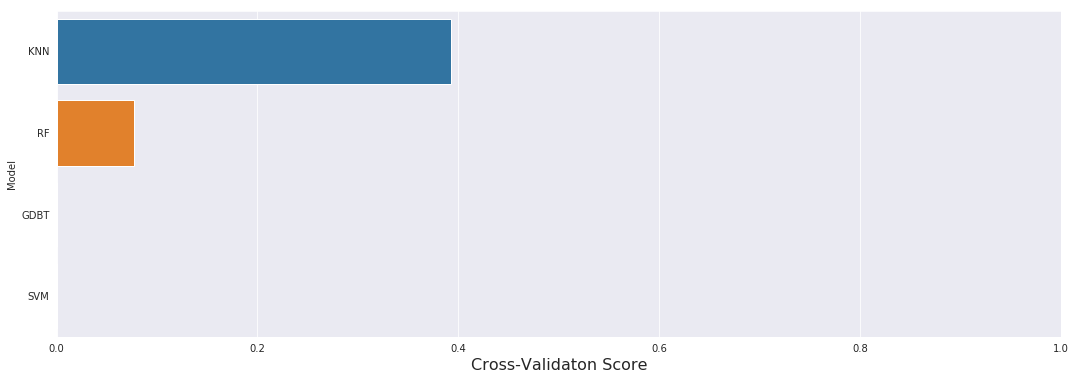

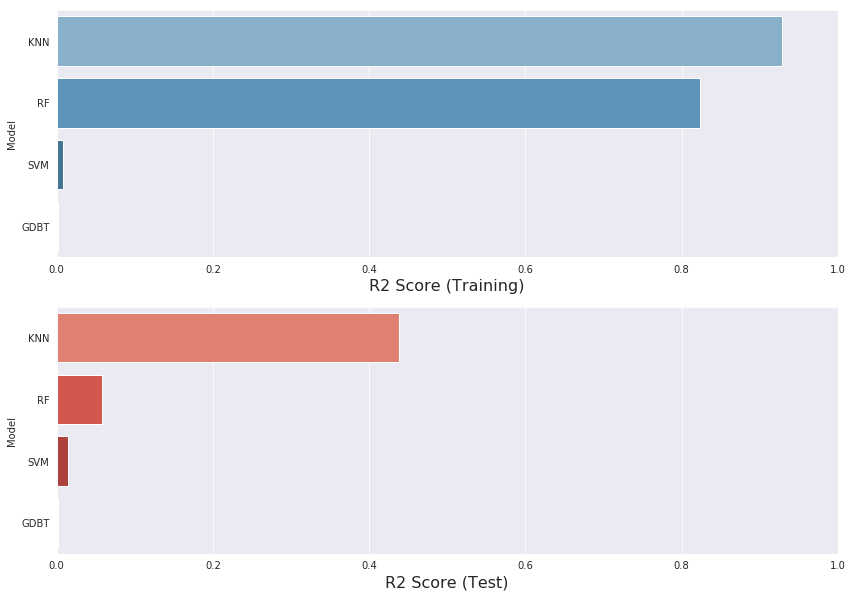

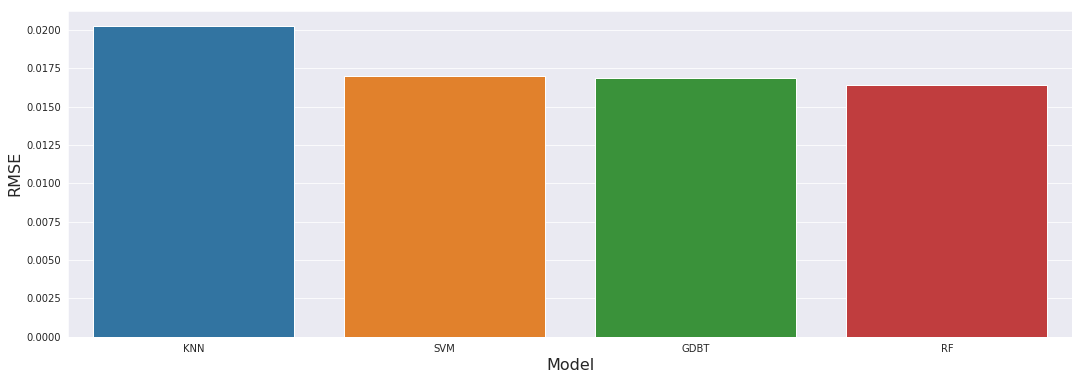

In [193]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 2. 30min model 

In [194]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,11]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1624, 2)
Shape of X_test:  (696, 2)
Shape of y_train:  (1624,)
Shape of y_test (696,)


In [195]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.008622207184444087
R2_score (train):  0.00181674730099457
R2_score (test):  0.0022219354300245797
RMSE:  0.016850907153326124


In [196]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.031071988455746345
R2_score (train):  0.007872464710977911
R2_score (test):  -0.014296124219108863
RMSE:  0.016989816671763167


In [197]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [198]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.3925360912475706
R2_score (train):  0.9292138451335975
R2_score (test):  -0.4389039949071871
RMSE:  0.02023588575354144


In [199]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  0.0766649199207846
R2_score (train):  0.8236759972676491
R2_score (test):  0.057705234166888
RMSE:  0.01637569342041018


In [200]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.016851            0.001817        0.002222         -0.008622
1   SVM  0.016990            0.007872        0.014296         -0.031072
2   KNN  0.020236            0.929214        0.438904          0.392536
3    RF  0.016376            0.823676        0.057705          0.076665

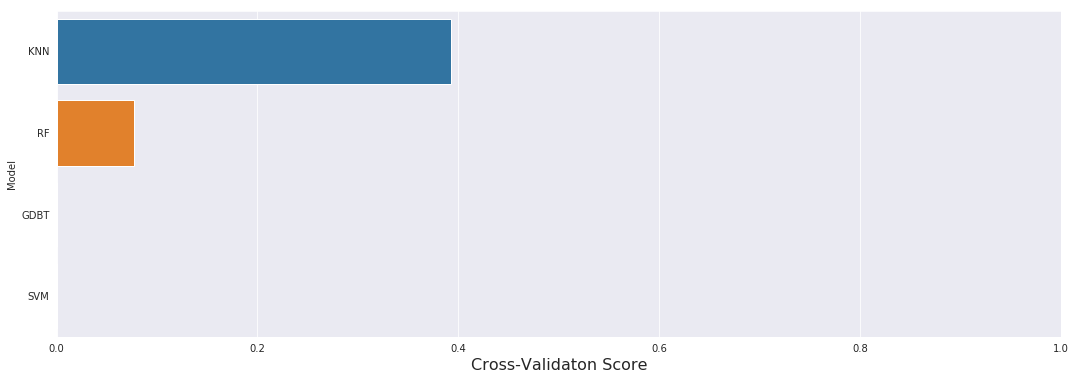

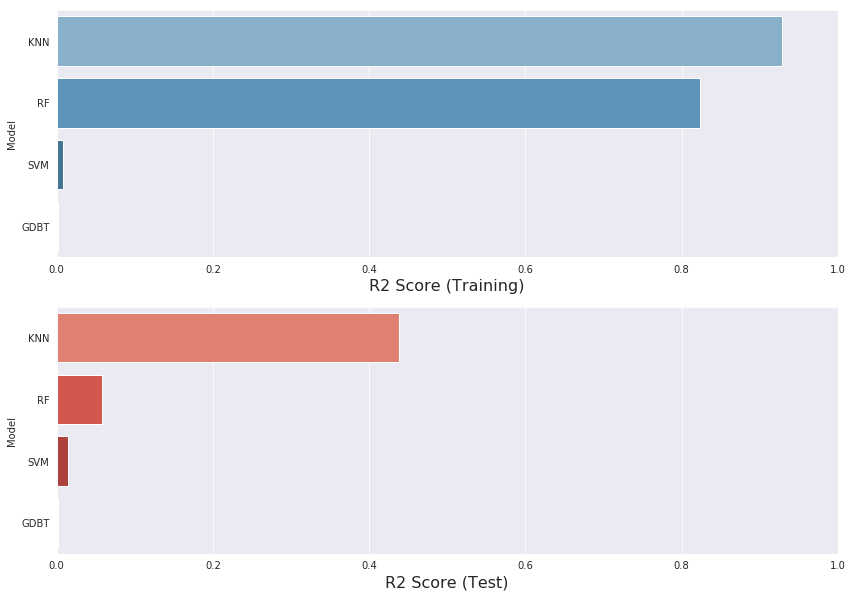

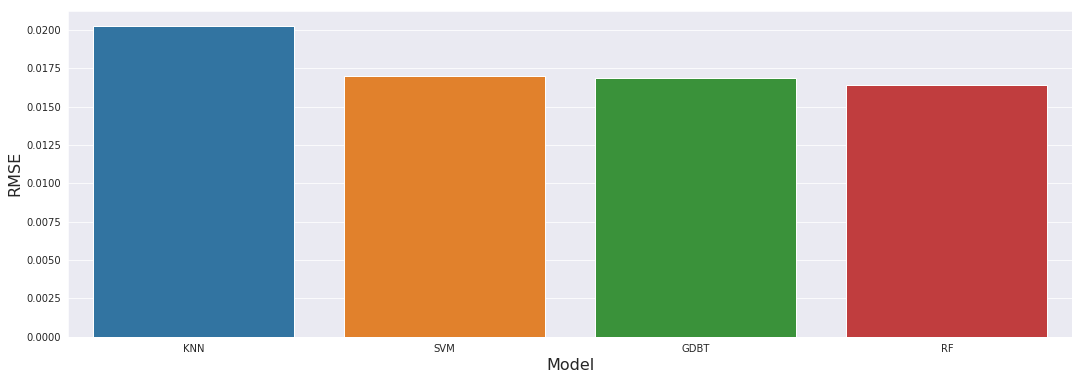

In [201]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 3. 1hour model 

In [202]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1624, 2)
Shape of X_test:  (696, 2)
Shape of y_train:  (1624,)
Shape of y_test (696,)


In [203]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.008622207184444087
R2_score (train):  0.00181674730099457
R2_score (test):  0.0022219354300245797
RMSE:  0.016850907153326124


In [204]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.031071988455746345
R2_score (train):  0.007872464710977911
R2_score (test):  -0.014296124219108863
RMSE:  0.016989816671763167


In [205]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [206]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.3925360912475706
R2_score (train):  0.9292138451335975
R2_score (test):  -0.4389039949071871
RMSE:  0.02023588575354144


In [207]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  0.0766649199207846
R2_score (train):  0.8236759972676491
R2_score (test):  0.057705234166888
RMSE:  0.01637569342041018


In [208]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.016851            0.001817        0.002222         -0.008622
1   SVM  0.016990            0.007872        0.014296         -0.031072
2   KNN  0.020236            0.929214        0.438904          0.392536
3    RF  0.016376            0.823676        0.057705          0.076665

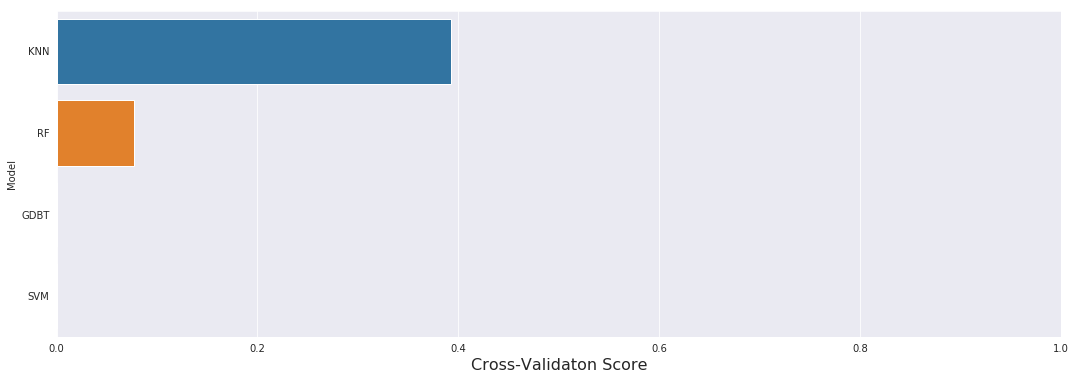

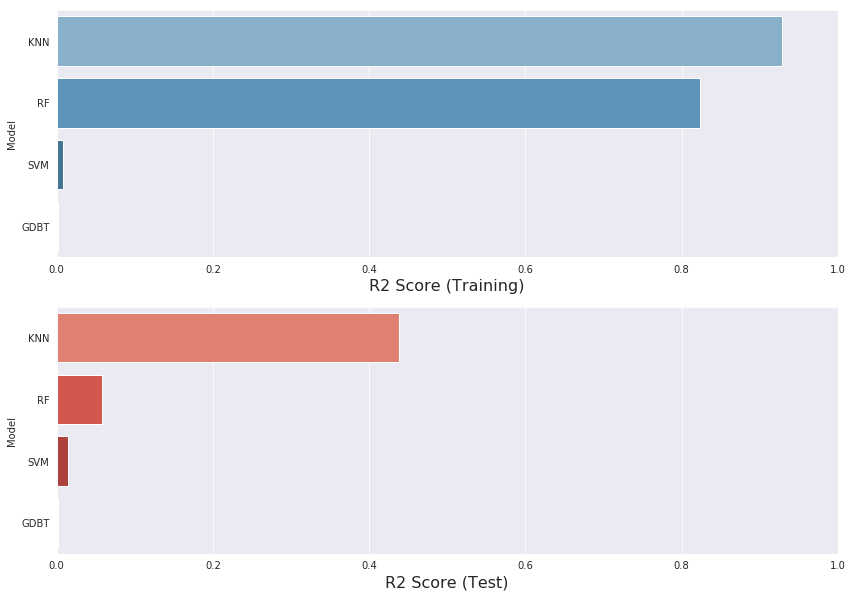

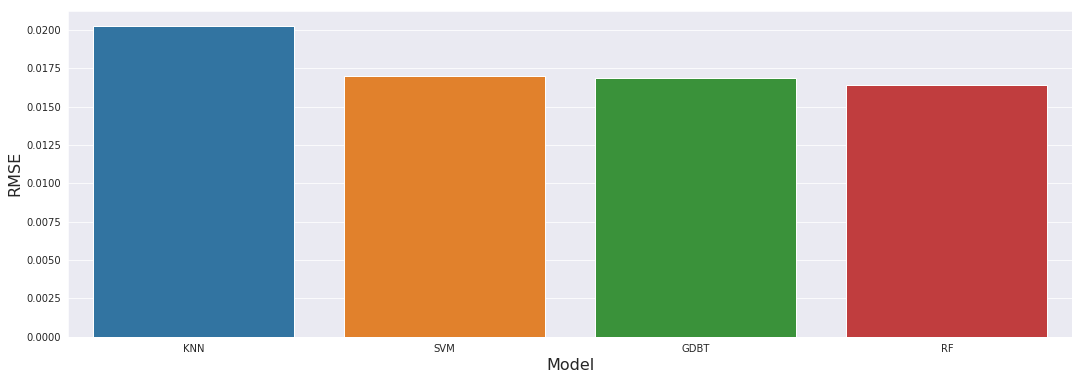

In [209]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 1. 1day model 

In [210]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1624, 2)
Shape of X_test:  (696, 2)
Shape of y_train:  (1624,)
Shape of y_test (696,)


In [211]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.008622207184444087
R2_score (train):  0.00181674730099457
R2_score (test):  0.0022219354300245797
RMSE:  0.016850907153326124


In [212]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.031071988455746345
R2_score (train):  0.007872464710977911
R2_score (test):  -0.014296124219108863
RMSE:  0.016989816671763167


In [213]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [214]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.3925360912475706
R2_score (train):  0.9292138451335975
R2_score (test):  -0.4389039949071871
RMSE:  0.02023588575354144


In [215]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  0.0766649199207846
R2_score (train):  0.8236759972676491
R2_score (test):  0.057705234166888
RMSE:  0.01637569342041018


In [216]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.016851            0.001817        0.002222         -0.008622
1   SVM  0.016990            0.007872        0.014296         -0.031072
2   KNN  0.020236            0.929214        0.438904          0.392536
3    RF  0.016376            0.823676        0.057705          0.076665

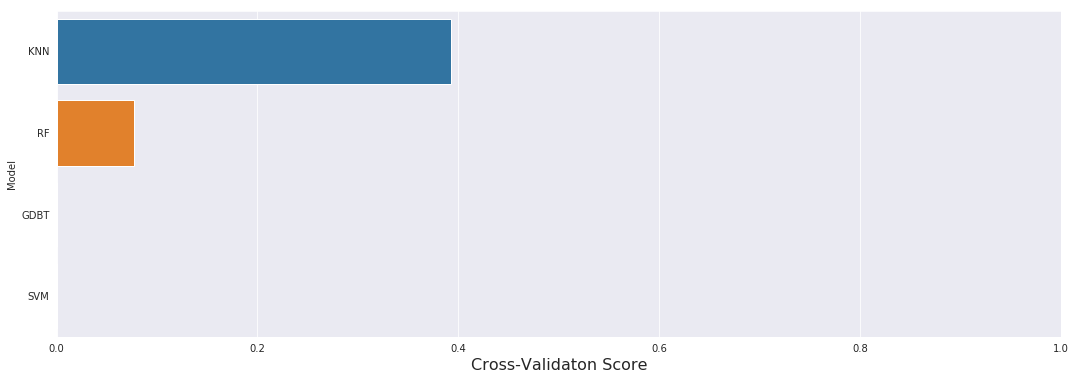

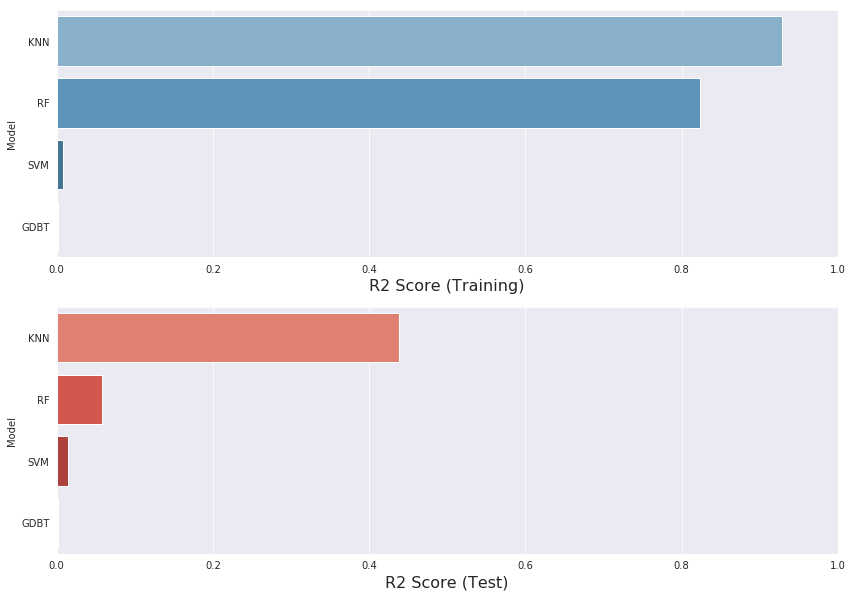

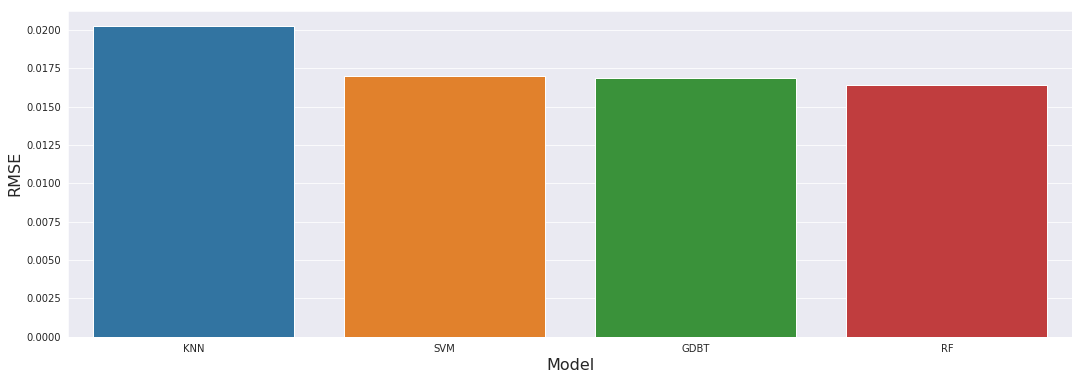

In [217]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

------------

**origin **

------------

In [ ]:
y = dataset.iloc[:,5]
X = dataset.drop('Premium', axis=1).iloc[:,:]

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

In [ ]:
dataset.head()

In [ ]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

### <span id="5"></span> ** Visualizing Data **

### <span id="5"></span> **Correlations can be found by thermal maps **

In [ ]:
corr = dataset.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

In [ ]:
sns.pairplot(dataset)
plt.show()

## <span id="6"></span> ** 4. Regression Models **

### <span id="7"></span> ** gdbt **

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

### <span id="11"></span> ** SVM **

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))

In [ ]:
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())

In [ ]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

In [ ]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#第五步：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression
print 'R-squared value of uniform-weighted KNR is',uni_knr.score(X_test,y_test)
print 'the MSE of uniform-weighted KNR is',mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(uni_knr_y_predict))
print 'the MAE of uniform-weighted KNR is',mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(uni_knr_y_predict))
#2.The prediction method is KNR according to the weighted distance
print 'R-squared value of distance-weighted KNR is',dis_knr.score(X_test,y_test)
print 'the MSE of distance-weighted KNR is',mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(dis_knr_y_predict))
print 'the MAE of distance-weighted KNR is',mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(dis_knr_y_predict))

In [ ]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

### <span id="13"></span> ** Random Forest Regression **

In [ ]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())

In [ ]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

## <span id="14"></span> ** 5. Measuring the Error **

In [ ]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]

In [ ]:
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

### <span id="15"></span> ** Visualizing Model Performance **

In [ ]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

In [ ]:
f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()

In [ ]:
predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="16"></span> ** 6. Conclusion **